# Installation of MTCNN Library

In [1]:
!pip install mtcnn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import necessary libraries

In [2]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Initialize MTCNN Face Detector

In [3]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()


# Automate the preprocessing 


FACELOADING Class Definition

In [4]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

Instantiate FACELOADING and Load/Extract Faces and Labels

In [5]:
faceloading = FACELOADING(r"E:\face_recognition-20251004T050428Z-1-001\face_recognition\Original Images")
X, Y = faceloading.load_classes()

Loaded successfully: 50
Loaded successfully: 92
Loaded successfully: 79
Loaded successfully: 72
Loaded successfully: 92
Loaded successfully: 68
Loaded successfully: 97
Loaded successfully: 120
Loaded successfully: 87
Loaded successfully: 78
Loaded successfully: 96
Loaded successfully: 80
Loaded successfully: 61
Loaded successfully: 71
Loaded successfully: 75
Loaded successfully: 105
Loaded successfully: 101
Loaded successfully: 112
Loaded successfully: 108
Loaded successfully: 28
Loaded successfully: 70
Loaded successfully: 72
Loaded successfully: 31
Loaded successfully: 105
Loaded successfully: 102
Loaded successfully: 112
Loaded successfully: 77
Loaded successfully: 58
Loaded successfully: 115
Loaded successfully: 49
Loaded successfully: 91


# FaceNet part 

Installation of keras-facenet Library

In [7]:
!pip install keras-facenet

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Initialize FaceNet Embedder Model

In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

# Define get_embedding function

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

Generate Embeddings for all Loaded Faces

In [9]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 158ms/step


In [10]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

Label Encoding and Train/Test Split

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

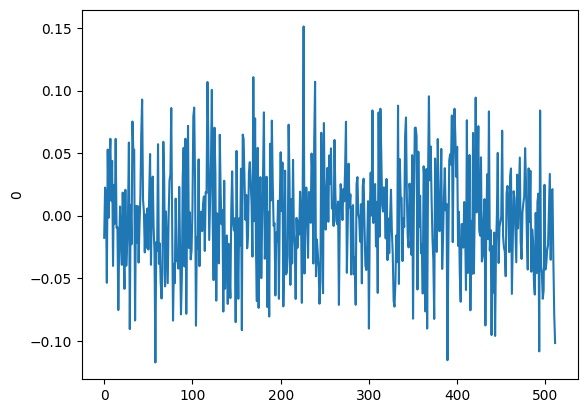

In [12]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [13]:
Y

array([ 0,  0,  0, ..., 30, 30, 30])

# Train Support Vector Machine (SVM) Classifier

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [15]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [16]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

0.9989556135770234

In [18]:
accuracy_score(Y_test,ypreds_test)

0.9968701095461658

# Real Time

read image detect face

In [29]:
t_im = cv.imread(r"C:\Users\DINESHKUMAR\Downloads\face_recognition-20251004T050428Z-1-001\face_recognition\sardor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

resize the image into array

In [30]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 102ms/step


predict the person name of face with our model 

In [31]:
test_im = [test_im]
ypreds = model.predict(test_im)

# save model for future 

In [20]:
!pip install pickle

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pickle


In [21]:
import pickle as p
p.dump(model, open('face_recognition_model.pkl', 'wb'))


In [34]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
t_im = cv.imread(r"C:\Users\DINESHKUMAR\Downloads\taylor.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [45]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 109ms/step


In [46]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [48]:
encoder.inverse_transform(ypreds)

array(['jenna_ortega'], dtype='<U18')